In [70]:
import collections
import matplotlib.pyplot as plt
import numpy as np

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def get_score_of_run(run):
    scores = [[x['f1score'],x['iterations_since_restore']] for x in run['results']]
    scores = np.array(scores)

    if len(scores) == 0: return 0, 0

    score, iteration = np.amax(scores,0)
    return score, iteration


In [71]:
import os
import json

RUNS_FOLDER = 'D:\\david_run_06_07\\'
RUNS_FOLDER = 'C:\\Informatik\\workspaces\\workspace_python\\AI-Cup\\aws_ray_results\\MergedTrainable_2022-07-08_22-00-00'
#RUNS_FOLDER = 'C:\\Informatik\\workspaces\\workspace_python\\AI-Cup\\aws_ray_results\\synced_folder\\PreprocessingTrainable_2022-06-13_11-10-00'

runs = []

for x in os.walk(RUNS_FOLDER):
    run_folder = x[0]

    params_path = os.path.join(run_folder,"params.json")
    result_path = os.path.join(run_folder,"result.json")

    if os.path.exists(params_path) and os.path.exists(result_path):
    
        p = open(params_path, encoding='utf-8')
        params = json.load(p)
        results =  [json.loads(line) for line in open(result_path, encoding='utf-8')]

        new_run = {
            'params': flatten(params),
            'results': results,
        }

        new_run_score, _  = get_score_of_run(new_run)

        if len(runs) == 0:
            runs.append(new_run)
            continue

        for i in range(len(runs)):
            run = runs[i]
            run_score, _ = get_score_of_run(run)

            if run_score >= new_run_score:
                runs.insert(i,new_run)
                break

            if i == len(runs) - 1: 
                runs.append(new_run)

        #if len(runs) > 100: break

# print([get_score_of_run(run)[0] for run in runs])

In [72]:
def group_values(values_all,n_groups):
    max_value = max(values_all)
    min_value = min(values_all)    

    group_range = (max_value - min_value) / (n_groups * 1.0)

    group_lengths = [0] * n_groups

    new_values = [None] * len(values_all)
    for i in range(n_groups):

        lower = min_value + group_range * i
        upper = min_value + group_range * (i+1)

        new_value = (lower + upper) / 2

        for j in range(len(values)):
            value = values[j]
            
            if value >= lower and value <= upper: 
                new_values[j] = new_value
                group_lengths[i] += 1

    for i in range(len(new_values)):
        # if new_values[i] is None: print(f'None:{i}/{len(new_values)}: value={values[i]}')
        if new_values[i] is None: new_values[i] = max_value
    
    return new_values, group_lengths

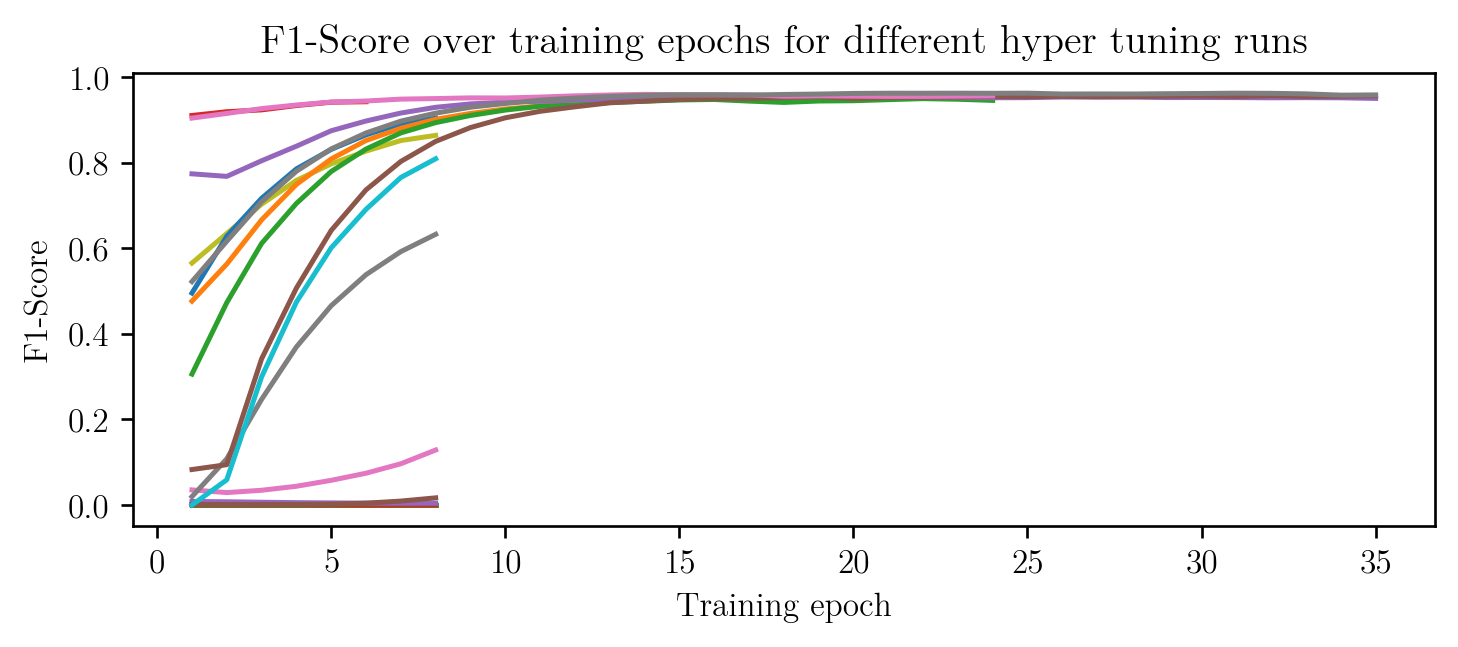

Best run: 0.964992384834539 at iteration 35.0
'additional_architectures_attention' : True
'additional_architectures_dense' : True
'additional_architectures_inception' : False
'additional_architectures_residual' : False
'attention_intermediate' : 0.6256165864753096
'attention_kernel' : 5
'backbone_length' : 5
'base_architecture' : U-net
'base_filter_count' : 29
'convolve_prob' : 0.8846490533608014
'convolve_window_size' : 2
'convolve_window_type' : parzen
'drift_kind' : multiplicative
'drift_max' : 0.2521286585014596
'drift_points' : 84
'drift_prob' : 0.7050274850972911
'dropout' : 0.379929390179037
'dropout_fill' : ffill
'dropout_percentage' : 0.299266342630388
'dropout_prob' : 0.27856210351883315
'dropout_size' : 2
'inception_kernel_size' : 6
'kernel_size' : 9
'loss' : tversky_loss
'lr_epoch_per_step' : 9
'lr_increase_per_step' : 0.1
'lr_number_of_steps' : 3
'lr_start' : 0.1
'meta' : False
'meta_dropout' : 0.7956428328917275
'n_fold_convolutions' : 1
'noise_prob' : 0.4032695885475437


In [73]:
import matplotlib
from utils.value_smoothing import smooth

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Latin Modern Roman'
matplotlib.rcParams['figure.dpi'] = 240

plt.rcParams["figure.figsize"] = (7,2.5)

f_scores = []
n = len(runs)
for i in range(0,n,55):
    scores = [[x['f1score'],x['iterations_since_restore']] for x in runs[i]['results']]
    scores = np.array(scores)

    if scores.size == 0: continue
    score, iteration = np.amax(scores,0)
    plt.plot(scores[:,1],smooth(scores[:,0],weight=0.7))
    f_scores.append(score)

#plt.ylim(0.94,0.97)
plt.title("F1-Score over training epochs for different hyper tuning runs")
plt.xlabel("Training epoch")
plt.ylabel("F1-Score")
plt.show()


max_fscore = np.max(f_scores)

for run in runs:
    score, it = get_score_of_run(run)
    if score == max_fscore:
        print(f"Best run: {score} at iteration {it}")
        for key in run['params']:
            print(f"'{key}' : {run['params'][key]}")

#plt.hist(f_scores, bins=100)
#plt.show()


In [74]:
import numpy as np
import pandas as pd
import math as math

from bokeh.plotting import figure, output_file, show, output_notebook

def create_box_plot(values, cats):
    
    df = pd.DataFrame(values)
    # find the quartiles and IQR for each category
    groups = df.groupby('group')
    q1 = groups.quantile(q=0.25)
    q2 = groups.quantile(q=0.5)
    q3 = groups.quantile(q=0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr

    # find the outliers for each category
    def outliers(group):
        cat = group.name
        return group[(group.score > upper.loc[cat]['score']) | (group.score < lower.loc[cat]['score'])]['score']
    out = groups.apply(outliers).dropna()

    # prepare outlier data for plotting, we need coordinates for every outlier.
    if not out.empty:
        outx = list(out.index.get_level_values(0))
        outy = list(out.values)

    p = figure(background_fill_color="#efefef", x_range=cats, width=600, height=400)

    # if no outliers, shrink lengths of stems to be no longer than the minimums or maximums
    qmin = groups.quantile(q=0.00)
    qmax = groups.quantile(q=1.00)
    upper.score = [min([x,y]) for (x,y) in zip(list(qmax.loc[:,'score']),upper.score)]
    lower.score = [max([x,y]) for (x,y) in zip(list(qmin.loc[:,'score']),lower.score)]

    # stems
    p.segment(cats, upper.score, cats, q3.score, line_color="black")
    p.segment(cats, lower.score, cats, q1.score, line_color="black")

    # boxes
    p.vbar(cats, 0.7, q2.score, q3.score, fill_color="#E08E79", line_color="black")
    p.vbar(cats, 0.7, q1.score, q2.score, fill_color="#3B8686", line_color="black")

    # whiskers (almost-0 height rects simpler than segments)
    p.rect(cats, lower.score, 0.2, 0.000001, line_color="black")
    p.rect(cats, upper.score, 0.2, 0.000001, line_color="black")

    # outliers
    if not out.empty:
        p.circle([str(x) for x in outx], outy, size=6, color="#F38630", fill_alpha=0.6)

    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = "white"
    p.grid.grid_line_width = 2
    p.xaxis.major_label_text_font_size="12px"
    p.xaxis.major_label_orientation = math.pi/4
    return p



In [75]:
def group_values(values,n_groups):
    max_value = max(values)
    min_value = min(values)    

    group_range = (max_value - min_value) / (n_groups * 1.0)

    group_lengths = [0] * n_groups

    new_values = [None] * len(values)
    for i in range(n_groups):

        lower = min_value + group_range * i
        upper = min_value + group_range * (i+1)

        new_value = (lower + upper) / 2

        for j in range(len(values)):
            value = values[j]
            
            if value >= lower and value <= upper: 
                new_values[j] = new_value
                group_lengths[i] += 1

    for i in range(len(new_values)):
        # if new_values[i] is None: print(f'None:{i}/{len(new_values)}: value={values[i]}')
        if new_values[i] is None: new_values[i] = max_value
    
    return new_values, group_lengths

In [76]:
def create_group_labels(value_set):


    try:
        l = list(value_set)
        l.sort()
        value_set = l
        
    except Exception as e:
        print(f"That did not work!: {e}")
        pass

    cast = lambda value : "None" if value is None else str(round(value,ndigits=5)) if type(value) == float else str(value)
    labels = [cast(value) for value in list(value_set)]

    return labels

In [77]:
labels_map = {

    # Augmention
    'convolve_prob': 'Augmentation: Convolution probability',
    'convolve_window_size': 'Augmentation: Convolution window size',
    'convolve_window_type': 'Augmentation: Convolution window type',

    'noise_prob': 'Augmentation: Noise probability',
    'noise_scale': 'Augmentation: Noise scale',

    'drift_prob': 'Augmentation: Drift probability',
    'drift_points': 'Augmentation: Number of drift points',
    'drift_kind': 'Augmentation: Drift kind',
    'drift_max': 'Augmentation: Drift maximum',

    'dropout_prob': 'Augmentation: Dropout probability',
    'dropout_size': 'Augmentation: Dropout size',
    'dropout_fill': 'Augmentation: Dropout fill',
    'dropout_percentage': 'Augmentation: Dropout percentage',


    'time_warp_prob': 'Augmentation: Time warp probability',
    'time_warp_max': 'Augmentation: Time warp maximum value',
    'time_warp_changes': 'Augmentation: Time warp number of changes',

    # Normalisierung
    'normalization_settings_normalization_mode': 'Normalization: Mode',
    'normalization_settings_normalization_function': 'Normalization: Function',

    # Training 
    'loss': 'Training: loss function',
    'tversky_beta': 'Training: Tversky loss: Beta parameter',
    'optimizer': 'Training: Optimizer',
    'meta': 'Add meta data to input data',

    'lr_start': 'Dynamic learning rate: Start value',
    'lr_number_of_steps': 'Dynamic learning rate: Number of steps ',
    'lr_epoch_per_step': 'Dynamic learning rate: Epochs per step',
    'lr_increase_per_step': 'Dynamic learning rate: Increase per step',

    # Ubernet
    'base_architecture': 'Uebernet: Base architecture',
    'backbone_length': 'Uebernet: Backbone length',
    'kernel_size': 'Uebernet: Kernel size',
    'base_filter_count': 'Uebernet: Number of base filters',

    'n_fold_convolutions': 'Uebernet: Number of fold convolutions',
    'dropout': 'Uebernet: Dropout',
    'meta_dropout': 'Uebernet: Metadata dropout',

    'additional_architectures_residual': 'Uebernet: Use "Residual" as additional architecture',

    'additional_architectures_inception': 'Uebernet: Use "Inception" as additional architecture',
    'inception_kernel_size': 'Uebernet: Inception kernel size',

    'additional_architectures_attention': 'Uebernet: Use "Attention" as additional architecture',
    'attention_intermediate': 'Uebernet: Attention intermediate',
    'attention_kernel': 'Uebernet: Number of attention kernels',

    'additional_architectures_dense':'Uebernet: Use "Dense" as additional architecture',

}



normalization_function_labels = {
    'min_max_symmetrical': f'Min-Max\nnorm.',
    'standardization': f'Standard-\nization',
    'decimal_scaling_normalization': f'Decimal-\nscaling',
    'tanh_estimator': f'Tanh\nestimator',
    'median_normalization': f'Median\nnorm.',
    'sigmoid_normalization': f'Sigmoid\nnorm.',
}

normalization_mode_labels = {
    'by_all': 'by all time series',
    'by_time_series': 'by specific time series',
}

['BinaryCrossentropy', 'dice_loss', 'tversky_loss']

loss_labels = {
    'BinaryCrossentropy': 'Binary crossentropy',
    'dice_loss': 'Dice loss',
    'tversky_loss': 'Tversky loss',


}

In [ ]:
for value in labels_map.values():
    print(value)

In [78]:
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.layouts import column
from utils.util_functions import create_folder_if_not_exists
import numpy as np

import matplotlib.pyplot as plt

get_score_by_best_runs = lambda n : get_score_of_run(runs[-n])[0]

#MINIMUM_SCORE = 0.90
N_BEST_RUNS = round(len(runs) * 0.5)
MINIMUM_SCORE = get_score_by_best_runs(N_BEST_RUNS)
params = set()
for run in runs: params.update(run['params'].keys())

plots = []
plt.rcParams["figure.figsize"] = (5,15)

### PLOTTE DIE BESTEN 100 im Vergleich zu allen!

create_folder_if_not_exists("hyperanalze")
fig = plt.figure(constrained_layout=True)

n_rows = len(labels_map.keys())
fig.set_size_inches(12,3 * n_rows)
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=n_rows, ncols=1)
i = 0
for param in labels_map.keys():

    values = []
    scores = []

    values_all = []
    scores_all = []

    for run in runs:
        param_value = run['params'][param]
        best_score, iteration = get_score_of_run(run)

        values_all.append(param_value)
        scores_all.append(best_score)

        if best_score > MINIMUM_SCORE:
            values.append(param_value)
            scores.append(best_score)

    if type(values[0]) == bool:
        values = [str(value) for value in values]
        values_all = [str(value) for value in values_all]


    values = [value if value is not None else str(value) for value in values]
    values_all = [value if value is not None else str(value) for value in values_all]

    try:
        value_set = set(values)
        value_set_all = set(values_all)
    except:
        continue
    
    # Create Figure
    subfig = subfigs[i]
    subfig.suptitle(labels_map[param], fontsize=16)
    axes = subfigs[i].subplots(nrows=1, ncols=2)
    axes[0].set_title("Option distribution")
    axes[1].set_title("F1-Score across best 50% of all runs")
    #plt.tight_layout()

    if(len(value_set_all) < 10): 
        bins = len(value_set_all)
    else:
        N_BINS = 10
        min_value = min(values_all)
        max_value = max(values_all)

        bin_range = (max_value - min_value) / N_BINS
        
        bins = [min_value + x * bin_range for x in range(N_BINS + 1)]

    values_extended = values.copy()
    values_extended.extend(list(value_set_all))
    scores_extended = scores.copy()
    scores_extended.extend([np.average(scores_extended)] * len(value_set_all))

    if param == 'normalization_settings_normalization_function':
        values_all = [normalization_function_labels[x] for x in values_all]
        values_extended = [normalization_function_labels[x] for x in values_extended]

    if param == 'normalization_settings_normalization_mode':
        values_all = [normalization_mode_labels[x] for x in values_all]
        values_extended = [normalization_mode_labels[x] for x in values_extended]

    if param == 'loss':
        values_all = [loss_labels[x] for x in values_all]
        values_extended = [loss_labels[x] for x in values_extended]

    n, bins, patches = axes[0].hist(values_all, density=True, bins=bins, facecolor='#ffa0a0',alpha=0.5, edgecolor='#000000', linewidth=1, label=["All values", "Best values"])
    axes[0].hist(values_extended, density=True, bins=bins, facecolor='#a0a0ff',alpha=0.5, edgecolor='#000000', linewidth=1, label="Best 50%")

    #axes[0].title(param)
    axes[0].legend()



    # Match X Sacle of both 
    # Use same value groups
    if (len(value_set) > 10): 
        values, value_lengths = group_values(values,10)
        value_set = set(values)
        print(value_lengths)
    
    value_score_map = {}

    for j in range(len(values)):
        value = values[j]
        score = scores[j]

        if value in value_score_map: 
            value_score_map[value].append(score)
        else:
            value_score_map[value] = [score]


    keys = list(value_score_map.keys())
    conds =[type(key) == float or type(key) == int for key in keys]
    if all(conds):
        print(f"Sorting {param}")
        keys.sort()
    
    labels = [ round(x,ndigits=2) if type(x) == float else x for x in keys]

    if param == 'normalization_settings_normalization_function':
        labels = [normalization_function_labels[x] for x in labels]

    if param == 'normalization_settings_normalization_mode':
        labels = [normalization_mode_labels[x] for x in labels]

    if param == 'loss':
        labels = [loss_labels[x] for x in labels]



    values = []
    for key in keys:
        values.append(value_score_map[key])

    axes[1].boxplot(values)
    axes[1].set_xticklabels(labels)


    #plt.savefig(f"hyperanalze/{param}_hist.png")

    i += 1


plt.show()

plt.clf()
p = column(plots)

output_notebook()

output_file("ueber_analysis.html")
#show(p)


    

2022-07-10 23:58:22.095249   [UtilFunctions] Found an existing folder for hyperanalze
[27, 25, 31, 29, 42, 64, 73, 74, 63, 53]
Sorting convolve_prob
[102, 54, 48, 42, 67, 67, 40, 26, 22, 48]
Sorting convolve_window_size
[30, 44, 51, 59, 71, 62, 54, 43, 37, 30]
Sorting noise_prob
[32, 23, 33, 36, 40, 56, 58, 78, 64, 61]
Sorting noise_scale
[60, 65, 53, 50, 51, 41, 46, 35, 37, 42]
Sorting drift_prob
[32, 37, 35, 40, 57, 71, 74, 68, 49, 39]
Sorting drift_points
[27, 27, 37, 32, 37, 47, 79, 84, 67, 44]
Sorting drift_max
[46, 52, 63, 66, 55, 56, 54, 45, 26, 18]
Sorting dropout_prob
Sorting dropout_size
[24, 36, 37, 62, 64, 76, 61, 51, 41, 29]
Sorting dropout_percentage
[78, 61, 75, 54, 43, 45, 32, 38, 32, 23]
Sorting time_warp_prob
[26, 21, 26, 36, 43, 45, 51, 74, 85, 74]
Sorting time_warp_max
[42, 63, 70, 79, 76, 68, 49, 29, 15, 3]
Sorting time_warp_changes
[25, 26, 39, 37, 38, 53, 68, 76, 65, 54]
Sorting tversky_beta
Sorting lr_start
Sorting lr_number_of_steps
Sorting lr_epoch_per_step
So

Loading BokehJS ...

<Figure size 1200x3600 with 0 Axes>